# Lab 6: Random Forest Regression on Malagasy Mammal Traits

### Introduction
 In Lab 5, we used functional trait data on bird species to predict their presence in a given climate type. This week we are using regression tree models on a similar dataset, this one on mammal species.  Our goal is to predict the total number of climate types each mammal species inhabits.

You will compare performance of a single decision tree with a tuned random forest to get a sense of the effectiveness of ensemble methods with optimized hyperparameter values.

There is a fair amount of missing data in this set, which can lead to low reliability of feature splits, increased overfitting, and decreased accuracy of tree models. You will address this issue with a combination of variable omission and imputation.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

### Step 1: Read data and retain a subset of the columns
Similar to last week, we will need to take some steps to get the data in a usable form. We again reformat the diet-related variable names to match this set: `Diet_Vertebrates`,
    `Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`. Then drop columns that are not relevant functional traits or climate type variables.   Next, drop any remaining  variables that have greater than 40% of the observations missing. Print the final dataframe shape. 

In [2]:
dat = pd.read_csv("/courses/EDS232/Data/MamTraitData.csv", encoding="ISO-8859-1", na_values=-999).rename(columns={
    'Diet: invertebrates': 'Diet_Invertebrates',
    'Diet: vertebrates': 'Diet_Vertebrates',
    'Diet: fruits': 'Diet_Fruits',
    'Diet: flower/nectar/pollen/gums': 'Diet_Flowers',
    'Diet: seeds': 'Diet_Seeds',
    'Diet: other plant materials': 'Diet_Plants',
    'Diet: scavenge; garbage; carrion; carcasses': 'Diet_Other'
})

# All columns appear to be relevant to functional traits or climate

# Drop variables that have more than 40% observations missing
data = dat.dropna(thresh=0.4 * len(dat), axis=1).copy()  # Copy to avoid SettingWithCopyWarning

print(f"Initial DataFrame shape: {dat.shape} ")
print(f"Final DataFrame shape: {data.shape} ")

Initial DataFrame shape: (214, 24) 
Final DataFrame shape: (214, 18) 


### Step 2: Imputation with KNN
Now impute the values of the missing data in the remaining numeric columns using k-nearest neighbors with `KNNImputer()`. Use the 5 nearest neighbors. This allows us to implement the knn algorithm to predict the missing values for an observation based on similar complete observations.Perform and print a check to ensure that there are no more NA values. 

In [3]:
# Count missing values before KNN imputation
print(f"Number of missing values before KNN imputation: {data.isna().sum().sum()}")

# Use KNNImputer on missing data
imputer = KNNImputer(n_neighbors=5)

# Select only numeric columns for imputation
numeric_data = data.select_dtypes(include=['number']).columns
data[numeric_data] = imputer.fit_transform(dat[numeric_data])

# Ensure no missing values remain
print(f"Number of missing values after imputation: {data.isna().sum().sum()}")
print(f"Final DataFrame shape: {data.shape}")

data.columns

Number of missing values before KNN imputation: 381
Number of missing values after imputation: 105
Final DataFrame shape: (214, 18)


Index(['AdultBodyMass', 'Diet_Invertebrates', 'Diet_Vertebrates',
       'Diet_Fruits', 'Diet_Flowers', 'Diet_Seeds', 'Diet_Plants',
       'Diet_Other', 'HabitatBreadth', 'ActivityCycle', 'ForagingStratum',
       'GestationLength', 'LitterSize', 'Dry', 'Humid', 'Montane', 'Subarid',
       'Subhumid'],
      dtype='object')

### Step 3: Create target variable and numerical encoding 
Create the target variable (`nClimates`) representing the  number of climates in which a species was present. Then finish preparing the data to be used in our models.

- Create a new column `nClimates` that combines the information of the five climate type variables
- Drop the original `Dry`, `Humid`, `Montane`, `Subarid`, and `Subhumid` columns
- Encode categorical variables
- Split the dataset into training and test sets. Use a random state of 808. 

In [4]:
# Create a new column combining climate info
climate_columns = ['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid']
data['nClimates'] = data[climate_columns].sum(axis=1)

# Drop the original climate columns
data = data.drop(columns=climate_columns)

# Encode categorical variables
categorical_columns = data.select_dtypes(include=['object']).columns

# Initialize encoder
label_encoder = LabelEncoder()

# Loop through each categorical column and apply LabelEncoder
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])
    
# Split the dataset into training and test sets
X = data.drop('nClimates', axis=1) 
y = data['nClimates'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=808)

### Step 4: Train a decision tree
Train a single decision tree to predict the number of climate types inhabited by each species.

- Train a `DecisionTreeRegressor`.  Let's apply a constraint on its growth by not allowing the tree to grow further than 5 levels. Use a random state of 808. 
- Make predictions
- Visualize the decision tree using `plot_tree`
- Evaluate and print its performance using mse

Mean Squared Error: 2.5326021103112986


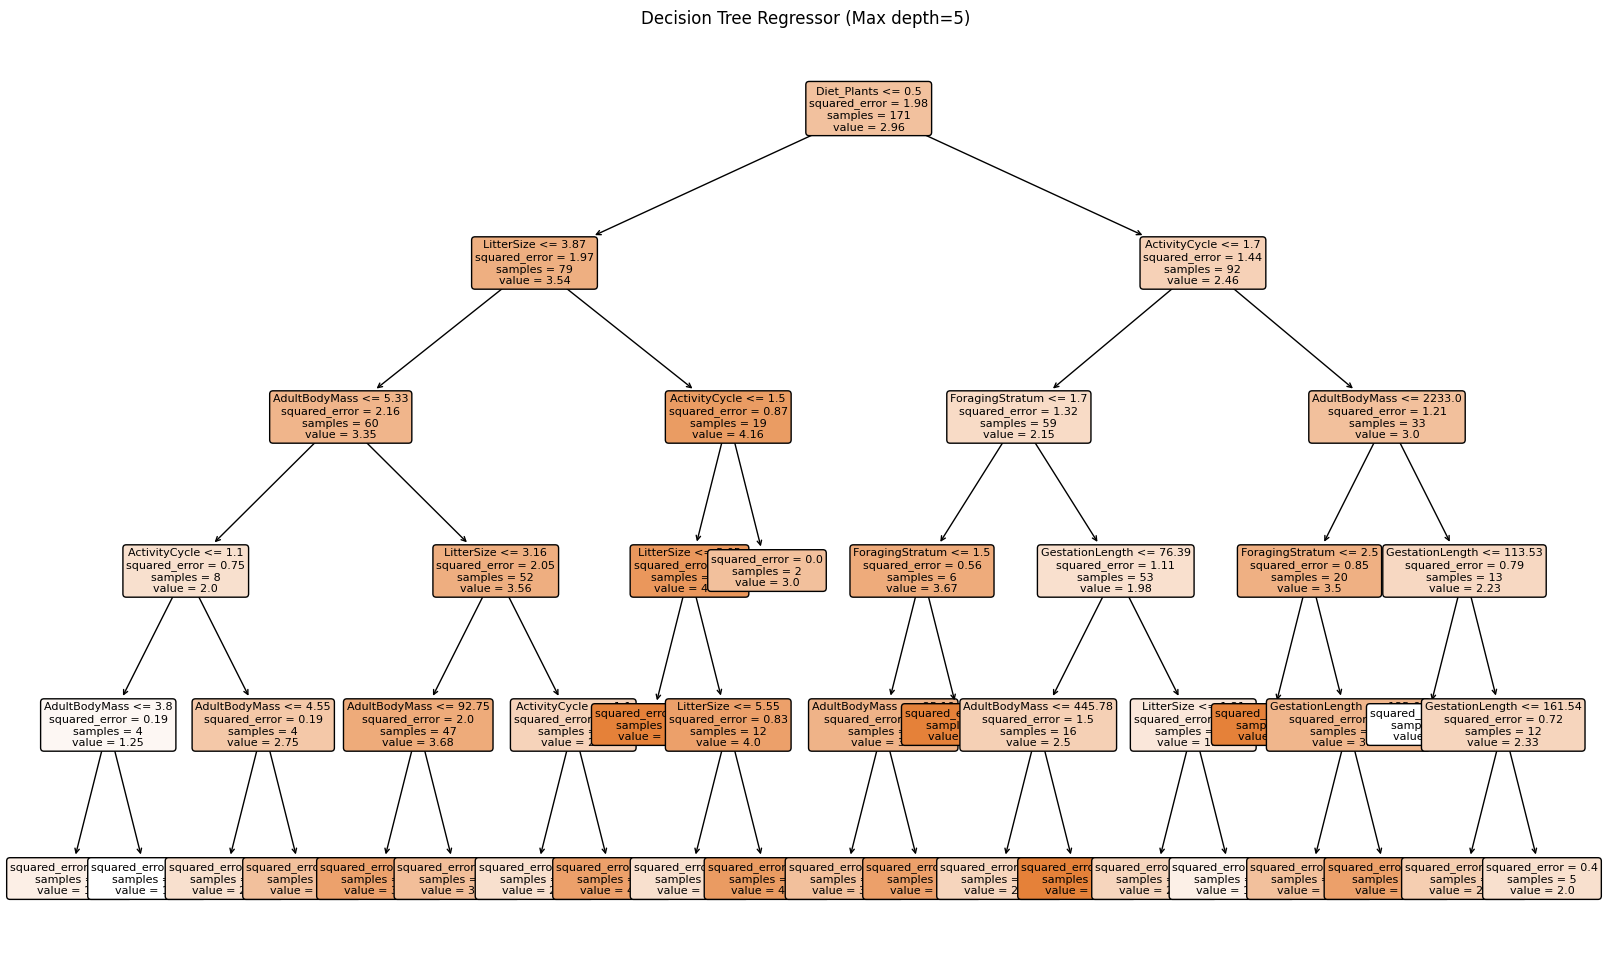

In [5]:
# Train DecisionTreeRegressor and fit the model
model = DecisionTreeRegressor(max_depth=5, random_state=808)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Print Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Visualize decision tree

# Initialize figure
plt.figure(figsize=(20, 12))

plot_tree(model, 
          filled=True, 
          feature_names=X.columns, 
          fontsize=8,  
          rounded=True,  # Round edges
          precision=2)  # Round decimals)

plt.title("Decision Tree Regressor (Max depth=5)")
plt.show()

Based on the way this tree looks, what would you guess the most important variable to be?

*Your answer here.*

### Step 5: Random forest with hyperparameter tuning
Now we'll use a more sophisticated ensemble approach where we optimize the values of key hyperparameters that govern tree growth.

- Define a parameter grid that includes the follow parameters and values:
  -  (sqrt(p), 6, and no set #) of the number of features to try at each split
  -  (50, 100, 200) total trees (learners)
  -  a maximum tree depth of (3,4,5,6,7)
  -  (2,5,10) minimum samples per split
  -  (1,2,4) minimum samples per leaf
  
- Use `GridSearchCV` with 5-fold cross-validation and mse (`neg_mean_squared_error`) to find the best combination of parameter values
- Train the best estimator.

In [6]:
# Define a parameter grid
param_grid = {
    'max_features': ['sqrt', 6, None], 
    'n_estimators': [50, 100, 200],    
    'max_depth': [3, 4, 5, 6, 7],       
    'min_samples_split': [2, 5, 10],    
    'min_samples_leaf': [1, 2, 4]       
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=808)

# Use GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error',  # Use negative MSE for scoring
                           cv=5) 

# Fit the model and print best parameters
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")

# Train the best estimator
best_rf = grid_search.best_estimator_

Best parameters: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


### Step 6: Make predictions and evaluate random forest model
Use the optimized random forest model (`best_rf`) to predict the number of climates a species inhabits and analyze its performance.

- Use `best_rf` and `predict()` method on `X_test` to generate predictions
- Print the best set of parameter values using thte `best_params` method
- Compute and print the mse to evaluate model performance
- Extract feature importance from the trained random forest model
- Visualize feature importance using a bar plot

In [7]:
# Generate predictions from best_rf
y_pred = best_rf.predict(X_test)

# Print the Best Set of Parameter Values
print("Best parameters using best_params method")
print(grid_search.best_params_)

# Compute and Print the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Extract Feature Importance from the Trained Random Forest Model
importance = best_rf.feature_importances_

Best parameters using best_params method
{'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Mean Squared Error (MSE): 1.5887497442233016


<Figure size 1000x600 with 0 Axes>

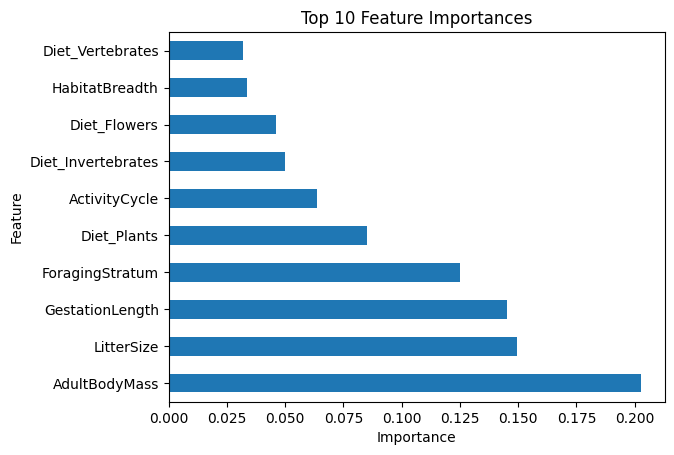

In [8]:
# Visualize Feature Importance using a Bar Plot

# Create a df to pair feature names with their importances, sort by importance
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Initialize figure
plt.figure(figsize=(10, 6))

importances_df.head(10).plot(kind='barh', x='Feature', y='Importance', legend=False)

plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

Which model had better accuracy, the single tree or the ensemble.  Interpret which traits have the most influence on species' climate adaptability.

*Your answer here.*